## Numerical experiments math and Data Science Project
#### Authors: Beltrame and Marchionne

In the following, we are presenting the results of the numerical experiments associated to the following papers:

- Training ReLU networks to high uniform accuracy is intractable; Julius Berner; Philipp Grohs and Felix Voigtlaender

- On the Complexity of Learning Neural Networks; Le Song et Al.

The numerical experiments aim to prove that we can find relevant and domain-specific problems of usign neural networks in solving even simple tasks.


## 1) x $\rightarrow$ log(sin(50x) + 2) + sin(5x)

In this example we can see that if we set an arbitrary resolution, the error associated with the 2-norm (the mean squared error) remains small, while the error associated with the 1-norm (the absolute error) presents bigger results.

This feature might lead to severe domain-specific issues when applied in a real-world scenario.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
    
# custom
from Functions import plot_result, MLPRegressor, create_dataset, StudentTeacher, ModelEvaluator, StudentNet, TeacherNet

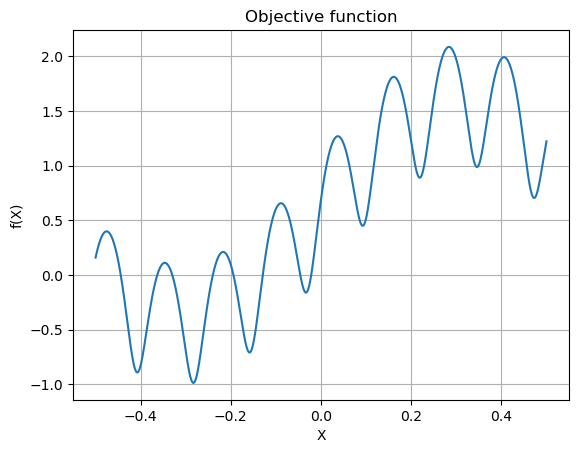

In [2]:
# define x
epsilon = 0.00001
x = np.arange(-0.5, 0.5, epsilon)
x_init = x
function = lambda x : np.log(np.sin(50 * x) + 2) + np.sin(5*x)
fx = [function(e) for e in x]
plot_result(x_init, fx, "X", "f(X)", "Objective function")

x_train, x_test, y_train, y_test = create_dataset(x, fx)



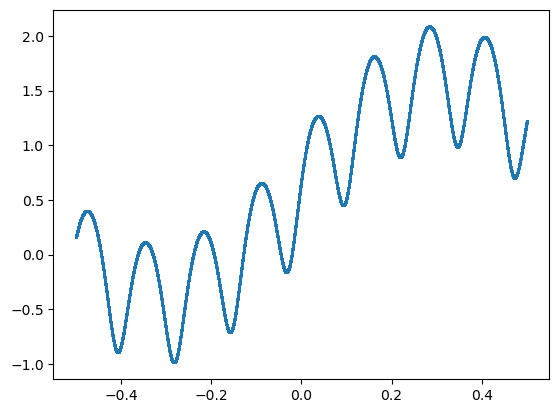

In [3]:
plt.scatter(x_train, y_train, 1)

We are using a support class that takes a *student teacher* neural network.

In [4]:
# width of the student MLP
hidden_size_s = [10, 20, 30]

#define students and teachers networks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a student-teacher object
st = StudentTeacher(device='cuda')

# Train the student network
st.fit(x_train, y_train, epochs=5000)

IndexError: index 13 is out of range

In [ ]:
st.plot_loss()
plt.scatter(x_test, st.predict(x_test))

In [12]:
# number of trials per layer width
T = 50
evaluator = ModelEvaluator(x_train, x_test, y_train, y_test, hidden_size_s, T)

In [ ]:
evaluator.train_models()

In [ ]:
evaluator.plot_models(R = 20)
plt.plot(x_init, fx, label="Target function")
plt.show()